## Step 1: Import Dependencies:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from torch_geometric.data import Data, Batch
import tqdm

In [3]:
print(torch.__version__)

2.6.0+cu124


## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [4]:
train_npz = np.load('/kaggle/input/cse251b//train.npz')
train_data = train_npz['data']
test_npz  = np.load('/kaggle/input/cse251b/test_input.npz')
test_data  = test_npz['data']

In [5]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [5]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

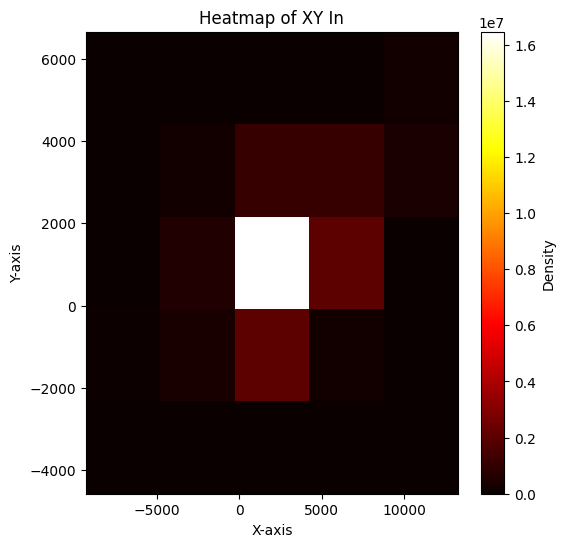

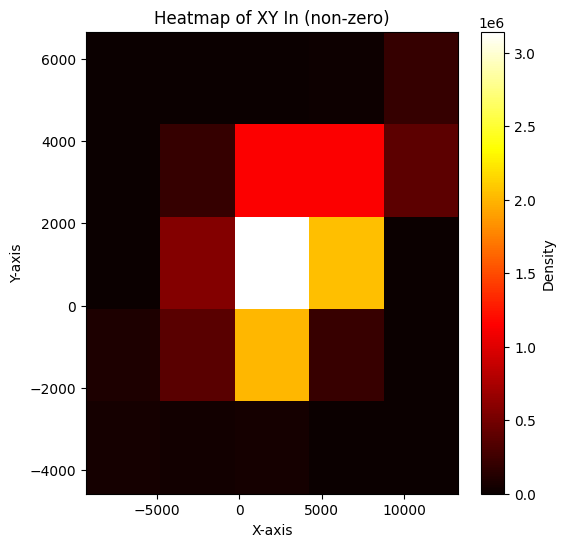

In [6]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

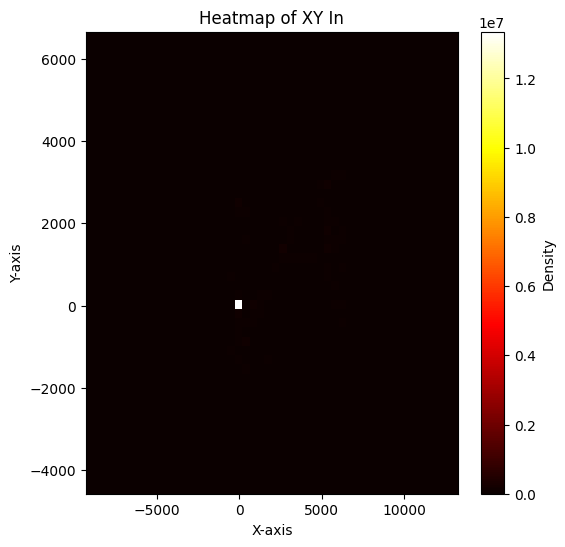

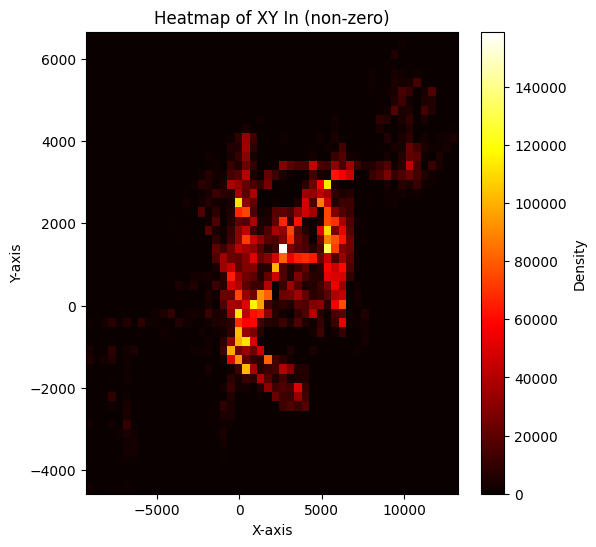

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

In [11]:
xy_out = train_data[:, 0, 50:, :2].reshape(-1, 2)
# only find the x, y != 0
xy_out_not_0 = xy_out[(xy_out[:, 0] != 0) & (xy_out[:, 1] != 0)]

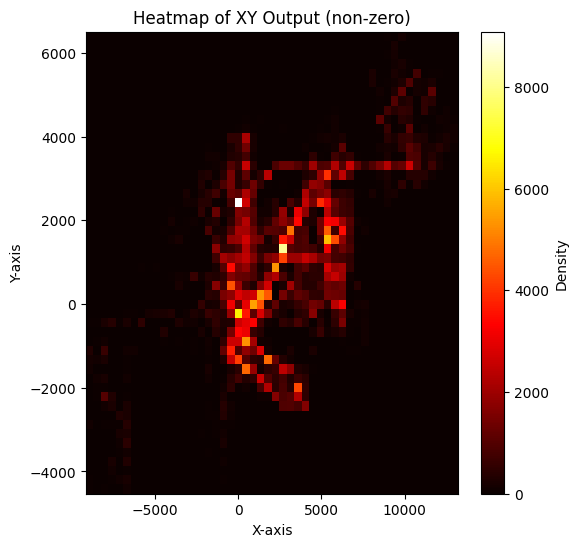

In [14]:
plot_heatmap(xy_out_not_0, title='Heatmap of XY Output (non-zero)', bins=50)

In [13]:
xy_out_not_0.shape, xy_in_not_0.shape

((600000, 2), (11684995, 2))

In [6]:
test_data.shape,train_data.shape

((2100, 50, 50, 6), (10000, 50, 110, 6))

In [7]:
labels = ['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus', 'static', 'background', 'construction', 'riderless_bicycle', 'unknown']

In [9]:
for i in range(10):
    found = test_data[np.where(test_data[:,:,:,5] == i)]
    foundt = train_data[np.where(train_data[:,:,:,5] == i)]
    velocity = np.sqrt(found[:,2]**2 +found[:,3]**2)
    velocityt = np.sqrt(foundt[:,2]**2 +foundt[:,3]**2)
    total = np.concatenate((velocityt,velocity)).flatten()
    print(labels[i],f'\tAverage Velocity: { np.average(total)}\tMax Velocity{np.max(total)}\t Min Velocity{np.min(total)}')


vehicle 	Average Velocity: 1.285357242770517	Max Velocity42.91051589694325	 Min Velocity0.0
pedestrian 	Average Velocity: 0.8118222030424611	Max Velocity27.69198355211162	 Min Velocity0.0
motorcyclist 	Average Velocity: 5.4578227419783865	Max Velocity30.713804217320178	 Min Velocity0.0
cyclist 	Average Velocity: 2.4787559644213046	Max Velocity31.378871345339768	 Min Velocity0.0
bus 	Average Velocity: 3.4623209827189756	Max Velocity31.544546272614983	 Min Velocity0.0
static 	Average Velocity: 0.0912955753631099	Max Velocity26.370744827000966	 Min Velocity0.0
background 	Average Velocity: 0.07065025404239353	Max Velocity36.76026013719925	 Min Velocity0.0
construction 	Average Velocity: 0.04807685536190018	Max Velocity26.91180980378865	 Min Velocity0.0
riderless_bicycle 	Average Velocity: 0.05427362368935452	Max Velocity28.311750716665642	 Min Velocity0.0
unknown 	Average Velocity: 0.07801250058596802	Max Velocity11.581884021531756	 Min Velocity0.0


In [17]:
print("Euclidean Distance of start/end")
for i in range(10):
    found = test_data[np.where(test_data[:,:,0,5] == i)]
    foundt = train_data[np.where(train_data[:,:,0,5] == i)]
    dist = np.sqrt((found[:,49,0]-found[:,0,0])**2 +(found[:,49,1]-found[:,0,1])**2)
    distt = np.sqrt((foundt[:,49,0]-foundt[:,0,0])**2 +(foundt[:,49,1]-foundt[:,0,1])**2)
    total = np.concatenate((distt,dist)).flatten()
    print(labels[i],f'\tAverage Distance: { np.average(total)}\tMax Distance{np.max(total)}\t Min Distance{np.min(total)}')


Euclidean Distance of start/end
vehicle 	Average Distance: 1103.5094061659975	Max Distance13935.920295147598	 Min Distance0.0
pedestrian 	Average Distance: 891.1698744854361	Max Distance13284.206986217148	 Min Distance0.00026577703005242965
motorcyclist 	Average Distance: 540.8299060104328	Max Distance9599.991128767935	 Min Distance0.004689875718549141
cyclist 	Average Distance: 657.1755883415267	Max Distance11131.901965229503	 Min Distance0.0011023757193880173
bus 	Average Distance: 341.0832785019471	Max Distance11022.211813391801	 Min Distance0.0002822045523473738
static 	Average Distance: 1032.1643010067394	Max Distance13278.529551343709	 Min Distance0.0004904586393498007
background 	Average Distance: 999.932909228883	Max Distance12703.94482686086	 Min Distance0.0003903953346670083
construction 	Average Distance: 958.1066673054509	Max Distance12281.968540986483	 Min Distance0.0005660008550419922
riderless_bicycle 	Average Distance: 699.1531109005807	Max Distance11700.146355732122	 M

In [38]:
testagents = test_data[:,:,0,5]
trainagents = train_data[:,:,0,5]
agents = np.concatenate((testagents,trainagents)).flatten()

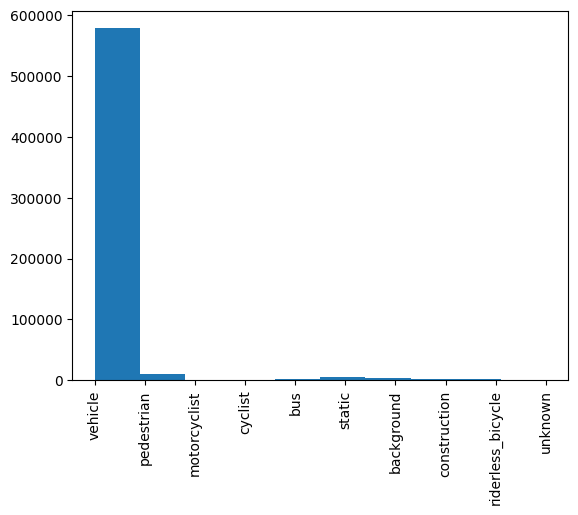

In [42]:
plt.hist(agents, bins=10) # Plots the histogram
plt.xticks([0,1,2,3,4,5,6,7,8,9],labels,rotation='vertical') # Sets the x-axis labels
plt.show()

In [45]:
nocar = agents[np.where(agents != 0)] -1

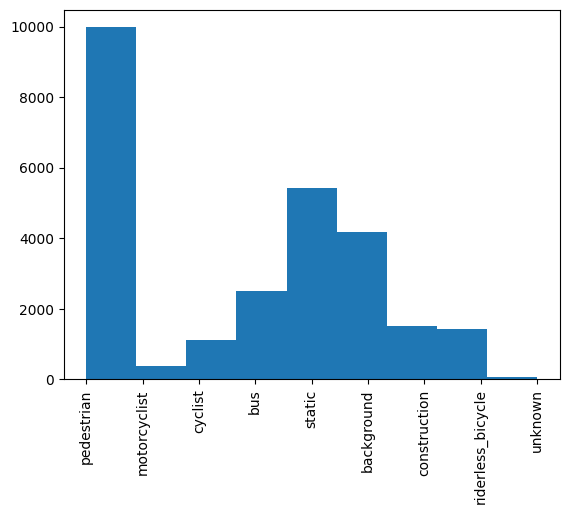

In [46]:
plt.hist(nocar, bins=9) # Plots the histogram
plt.xticks([0,1,2,3,4,5,6,7,8],labels[1:],rotation='vertical') # Sets the x-axis labels
plt.show()

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)